In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 手动实现的激活函数
class ManualReLU(nn.Module):
    def __init__(self):
        super(ManualReLU, self).__init__()
    
    def forward(self, x):
        return torch.maximum(x, torch.tensor(0.0))

class ManualSigmoid(nn.Module):
    def __init__(self):
        super(ManualSigmoid, self).__init__()
    
    def forward(self, x):
        return 1 / (1 + torch.exp(-torch.clamp(x, -250, 250)))

class ManualTanh(nn.Module):
    def __init__(self):
        super(ManualTanh, self).__init__()
    
    def forward(self, x):
        return torch.tanh(x)

# 手动实现的Dropout
class ManualDropout(nn.Module):
    def __init__(self, p=0.5):
        super(ManualDropout, self).__init__()
        self.p = p
        self.mask = None
    
    def forward(self, x, training=True):
        if training and self.p > 0:
            # 生成伯努利掩码
            self.mask = torch.bernoulli(torch.ones_like(x) * (1 - self.p)) / (1 - self.p)
            return x * self.mask
        return x

# 手动实现的L2正则化损失
def manual_l2_regularization(model, lambda_reg):
    """手动计算L2正则化损失"""
    l2_loss = 0.0
    for param in model.parameters():
        if param.requires_grad:
            l2_loss += torch.sum(param ** 2)
    return 0.5 * lambda_reg * l2_loss

# 前馈神经网络模型
class FeedForwardNetMNIST(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, 
                 activation='relu', dropout_rate=0.0, use_manual_dropout=True,
                 use_l2_regularization=False, l2_lambda=0.001):
        super(FeedForwardNetMNIST, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.use_manual_dropout = use_manual_dropout
        self.use_l2_regularization = use_l2_regularization
        self.l2_lambda = l2_lambda
        
        # 选择激活函数
        if activation == 'relu':
            self.activation = ManualReLU()
        elif activation == 'sigmoid':
            self.activation = ManualSigmoid()
        elif activation == 'tanh':
            self.activation = ManualTanh()
        else:
            raise ValueError("激活函数必须是 'relu', 'sigmoid', 或 'tanh'")
        
        # 构建网络层
        layers = []
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(self.activation)
            
            # 添加Dropout层（除了最后一层）
            if i < len(hidden_dims) - 1 and dropout_rate > 0:
                if use_manual_dropout:
                    layers.append(ManualDropout(dropout_rate))
                else:
                    layers.append(nn.Dropout(dropout_rate))
            
            prev_dim = hidden_dim
        
        # 输出层
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    
    def compute_regularization_loss(self):
        """计算正则化损失"""
        if self.use_l2_regularization:
            return manual_l2_regularization(self, self.l2_lambda)
        return 0.0

# 训练函数
def train_model(model, train_loader, test_loader, epochs=100, learning_rate=0.001, 
                verbose=True, early_stopping=True, patience=10):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    best_test_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # 训练模式
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # 前向传播
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # 添加手动L2正则化损失
            if model.use_l2_regularization:
                reg_loss = model.compute_regularization_loss()
                loss += reg_loss
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
            
            # 计算训练准确率
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # 计算平均训练损失和准确率
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # 评估模式
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                # 添加手动L2正则化损失（在评估时也计算，但不影响梯度）
                if model.use_l2_regularization:
                    reg_loss = model.compute_regularization_loss()
                    loss += reg_loss
                
                test_loss += loss.item() * batch_X.size(0)
                
                # 计算测试准确率
                _, predicted = torch.max(outputs.data, 1)
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
        
        test_loss = test_loss / len(test_loader.dataset)
        test_accuracy = test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # 早停机制
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
        else:
            patience_counter += 1
        
        # 打印训练进度
        if verbose and (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')
        
        # 检查早停
        if early_stopping and patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}, best Test Loss:{best_test_loss:.4f} at epoch {best_epoch} ')
            break
    
    # 加载最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    history = {
        'epochs': list(range(1, len(train_losses) + 1)),
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'test_loss': test_losses,
        'test_acc': test_accuracies
    }
    
    return history

# 评估函数
def evaluate_model(model, X_tensor, y_tensor, set_name="Dataset"):
    """评估模型性能"""
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predictions = torch.max(outputs.data, 1)
    
    y_true = y_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    
    # 计算指标
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"\n{set_name} Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # 绘制混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), 
                yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{set_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return accuracy

# 绘制训练历史
def plot_training_history(history, title="Training History"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 损失曲线
    ax1.plot(history['epochs'], history['train_loss'], label='Train Loss', linewidth=2)
    ax1.plot(history['epochs'], history['test_loss'], label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 准确率曲线
    ax2.plot(history['epochs'], history['train_acc'], label='Train Accuracy', linewidth=2)
    ax2.plot(history['epochs'], history['test_acc'], label='Test Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

使用设备: cuda


Loading MNIST dataset...


d:\Miniconda\envs\yolov5\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


训练集形状: X=(60000, 784), y=(60000,)
测试集形状: X=(10000, 784), y=(10000,)
开始对比实验...

训练配置: Baseline (ReLU, No Regularization)
Epoch [10/100], Train Loss: 0.0171, Train Acc: 0.9944, Test Loss: 0.0875, Test Acc: 0.9781
Epoch [20/100], Train Loss: 0.0094, Train Acc: 0.9968, Test Loss: 0.0909, Test Acc: 0.9812
Early stopping triggered at epoch 28, best Test Loss:0.0762 at epoch 7 

Train - Baseline (ReLU, No Regularization) Evaluation Results:
Accuracy: 0.9933

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5917
           1       1.00      0.99      1.00      6752
           2       1.00      0.98      0.99      5991
           3       0.99      0.99      0.99      6121
           4       0.99      1.00      1.00      5849
           5       1.00      0.98      0.99      5411
           6       1.00      1.00      1.00      5894
           7       0.99      1.00      0.99      6251
           8       0.98      1.00 

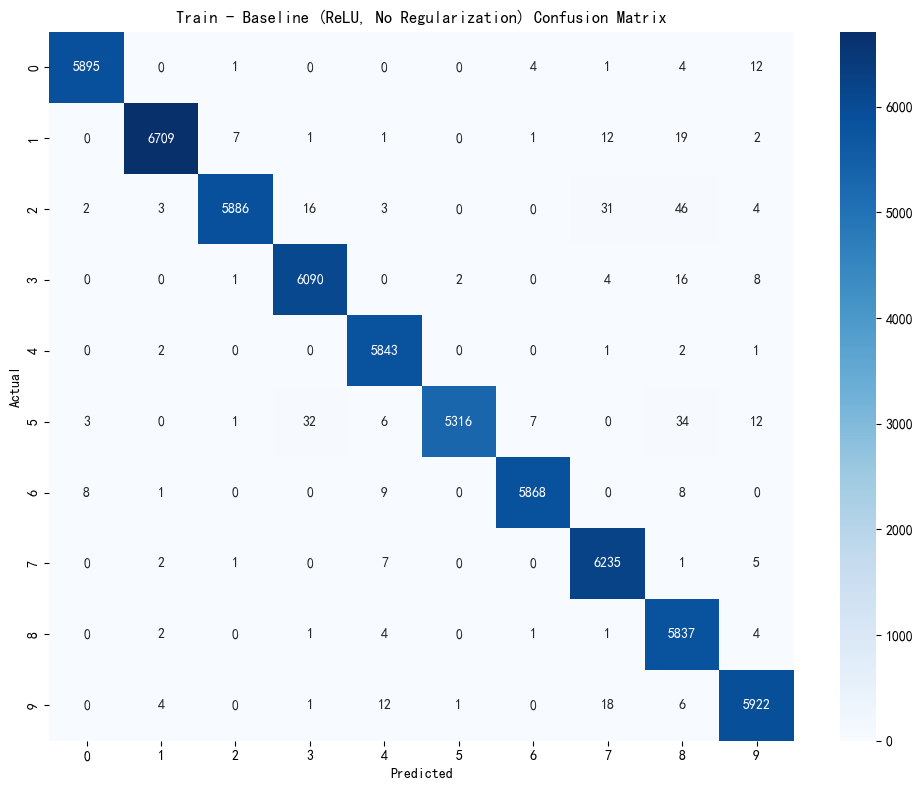


Test - Baseline (ReLU, No Regularization) Evaluation Results:
Accuracy: 0.9780

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       986
           1       0.99      0.99      0.99      1125
           2       0.99      0.96      0.98       999
           3       0.97      0.98      0.98      1020
           4       0.97      0.98      0.98       975
           5       0.99      0.96      0.97       902
           6       0.99      0.98      0.99       982
           7       0.97      0.98      0.97      1042
           8       0.96      0.98      0.97       975
           9       0.95      0.97      0.96       994

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



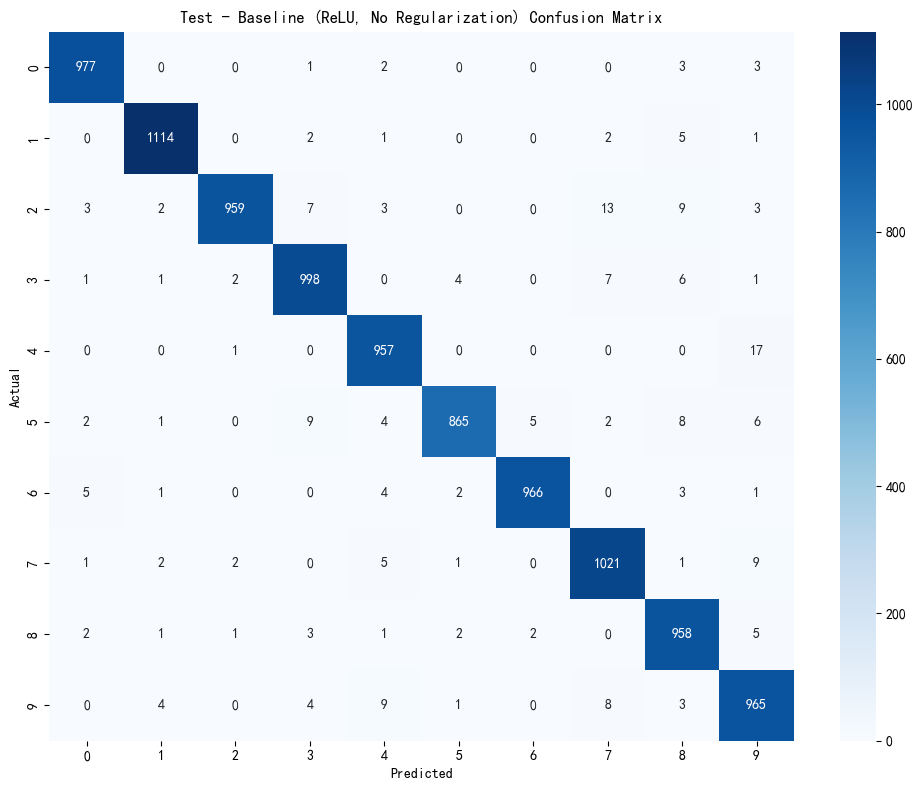

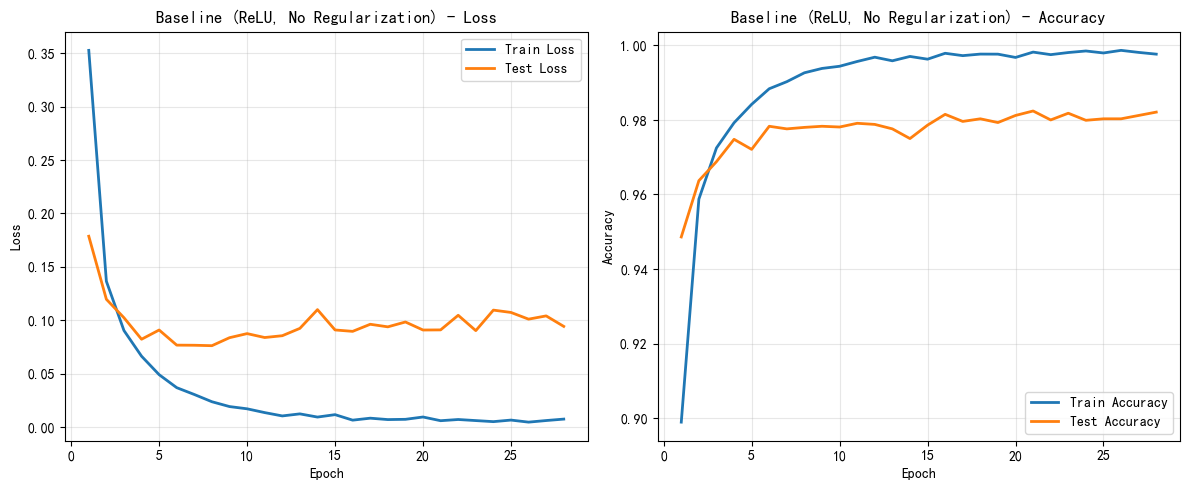


训练配置: Sigmoid Activation (No Regularization)
Epoch [10/100], Train Loss: 0.0388, Train Acc: 0.9891, Test Loss: 0.0738, Test Acc: 0.9777
Epoch [20/100], Train Loss: 0.0055, Train Acc: 0.9989, Test Loss: 0.0808, Test Acc: 0.9792
Epoch [30/100], Train Loss: 0.0004, Train Acc: 1.0000, Test Loss: 0.0855, Test Acc: 0.9825
Early stopping triggered at epoch 33, best Test Loss:0.0705 at epoch 12 

Train - Sigmoid Activation (No Regularization) Evaluation Results:
Accuracy: 0.9971

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5917
           1       0.99      1.00      1.00      6752
           2       1.00      1.00      1.00      5991
           3       1.00      1.00      1.00      6121
           4       0.99      1.00      1.00      5849
           5       1.00      1.00      1.00      5411
           6       1.00      1.00      1.00      5894
           7       1.00      1.00      1.00      6251
           8

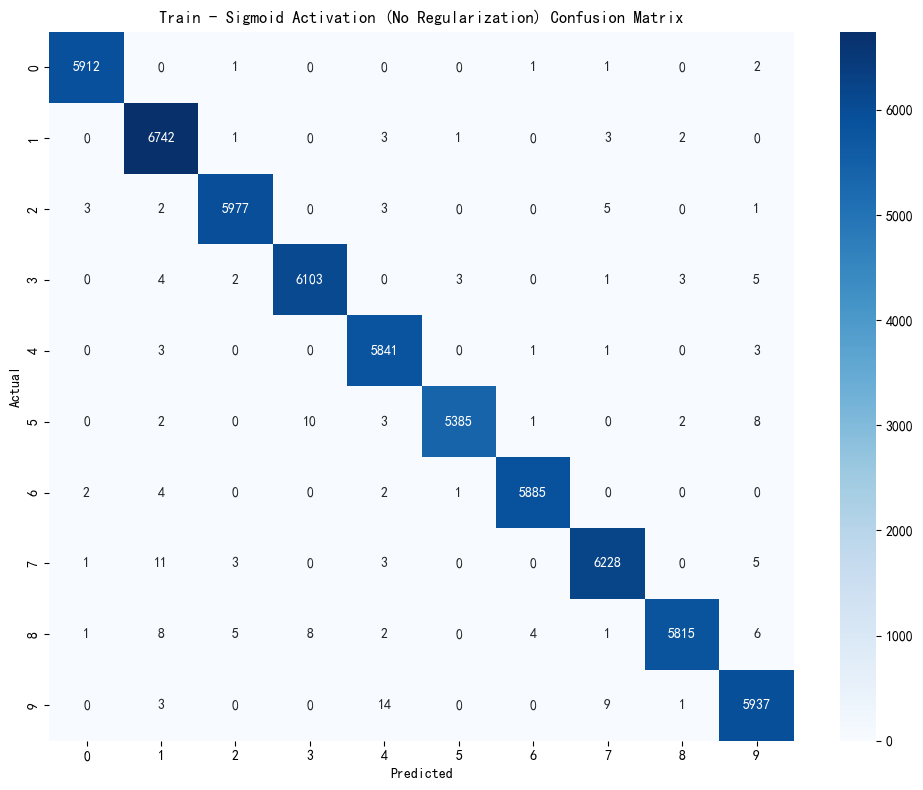


Test - Sigmoid Activation (No Regularization) Evaluation Results:
Accuracy: 0.9787

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       986
           1       0.98      0.99      0.99      1125
           2       0.99      0.98      0.98       999
           3       0.97      0.98      0.97      1020
           4       0.98      0.98      0.98       975
           5       0.98      0.97      0.97       902
           6       0.99      0.99      0.99       982
           7       0.98      0.98      0.98      1042
           8       0.98      0.96      0.97       975
           9       0.96      0.97      0.97       994

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



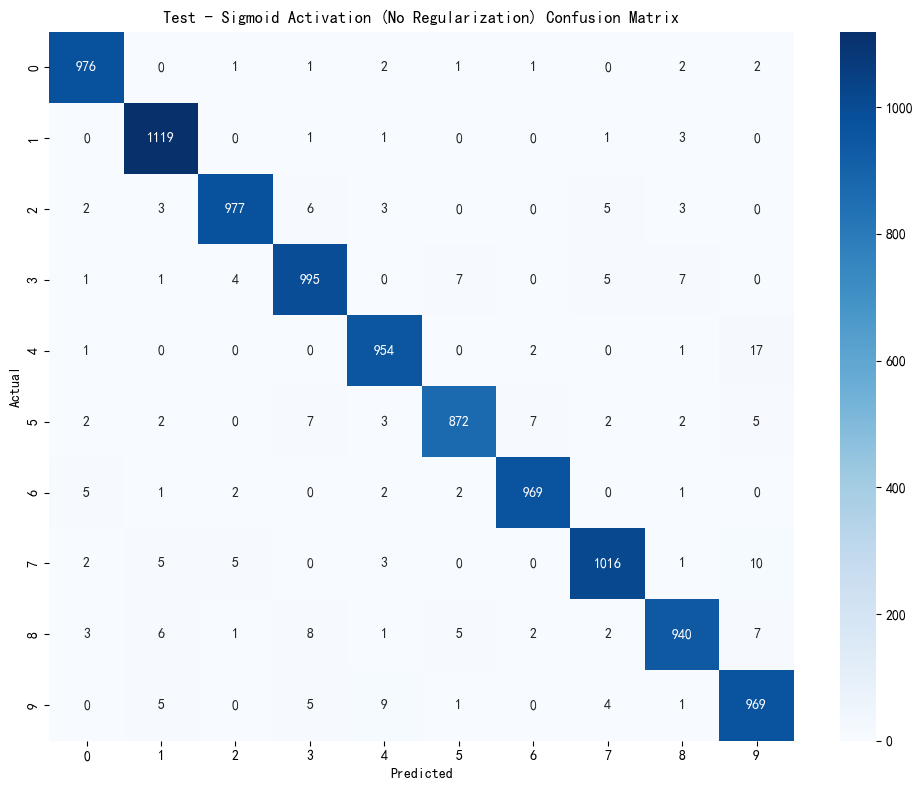

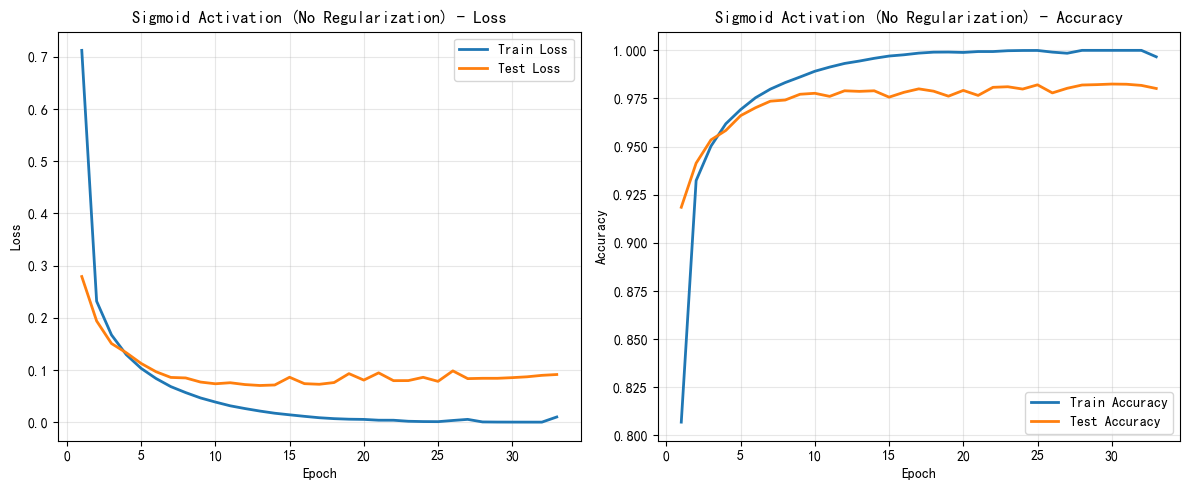


训练配置: Tanh Activation (No Regularization)
Epoch [10/100], Train Loss: 0.0142, Train Acc: 0.9960, Test Loss: 0.0840, Test Acc: 0.9768
Epoch [20/100], Train Loss: 0.0015, Train Acc: 0.9998, Test Loss: 0.0846, Test Acc: 0.9810
Early stopping triggered at epoch 27, best Test Loss:0.0753 at epoch 6 

Train - Tanh Activation (No Regularization) Evaluation Results:
Accuracy: 0.9942

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5917
           1       1.00      1.00      1.00      6752
           2       0.99      1.00      1.00      5991
           3       0.99      0.99      0.99      6121
           4       0.99      1.00      0.99      5849
           5       1.00      0.99      1.00      5411
           6       0.99      1.00      1.00      5894
           7       1.00      0.99      0.99      6251
           8       0.99      1.00      0.99      5850
           9       0.99      0.99      0.99      5964

 

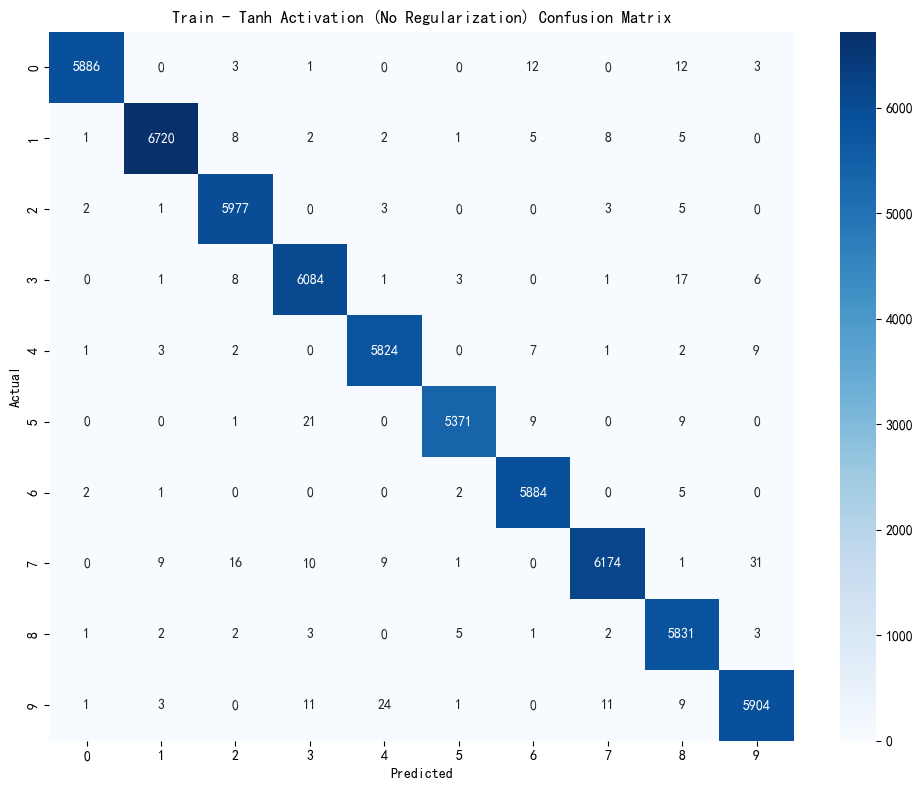


Test - Tanh Activation (No Regularization) Evaluation Results:
Accuracy: 0.9771

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       986
           1       0.98      0.99      0.99      1125
           2       0.97      0.98      0.98       999
           3       0.97      0.98      0.97      1020
           4       0.98      0.97      0.98       975
           5       0.98      0.97      0.98       902
           6       0.99      0.99      0.99       982
           7       0.98      0.96      0.97      1042
           8       0.96      0.97      0.97       975
           9       0.96      0.96      0.96       994

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



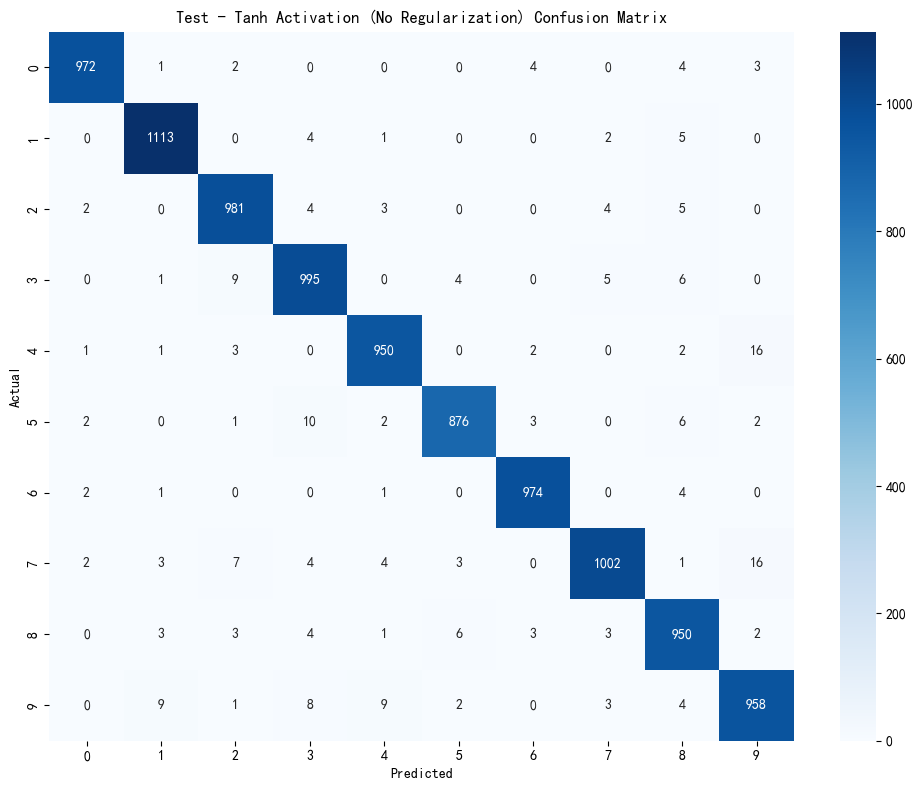

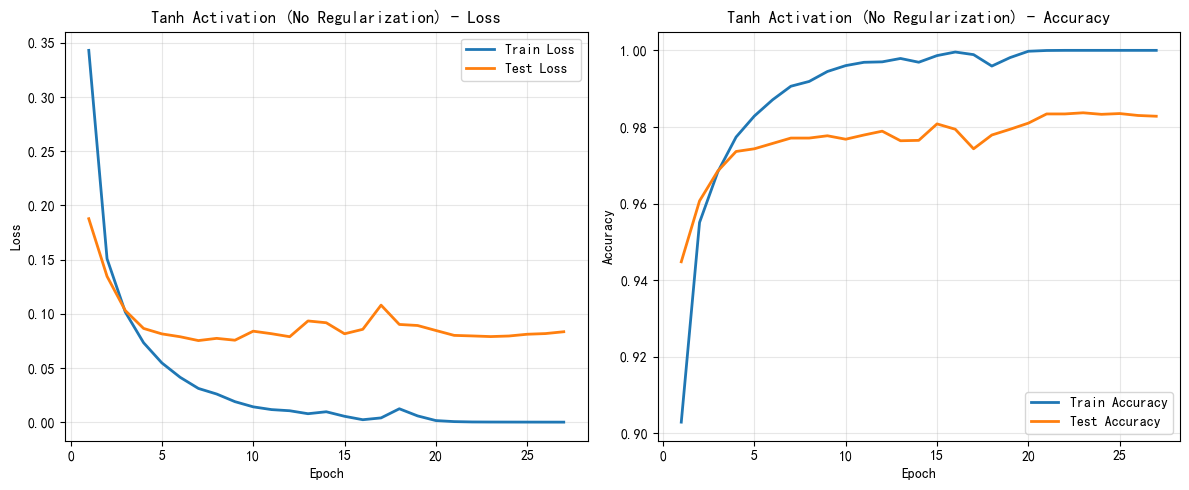


训练配置: Dropout (Low, rate=0.1)
Epoch [10/100], Train Loss: 0.0257, Train Acc: 0.9911, Test Loss: 0.0767, Test Acc: 0.9785
Epoch [20/100], Train Loss: 0.0143, Train Acc: 0.9951, Test Loss: 0.0899, Test Acc: 0.9802
Early stopping triggered at epoch 26, best Test Loss:0.0739 at epoch 5 

Train - Dropout (Low, rate=0.1) Evaluation Results:
Accuracy: 0.9898

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5917
           1       1.00      0.99      0.99      6752
           2       0.98      0.99      0.99      5991
           3       0.99      0.99      0.99      6121
           4       0.99      0.99      0.99      5849
           5       0.98      0.99      0.99      5411
           6       1.00      0.99      0.99      5894
           7       0.99      0.99      0.99      6251
           8       0.98      0.99      0.99      5850
           9       0.99      0.98      0.99      5964

    accuracy             

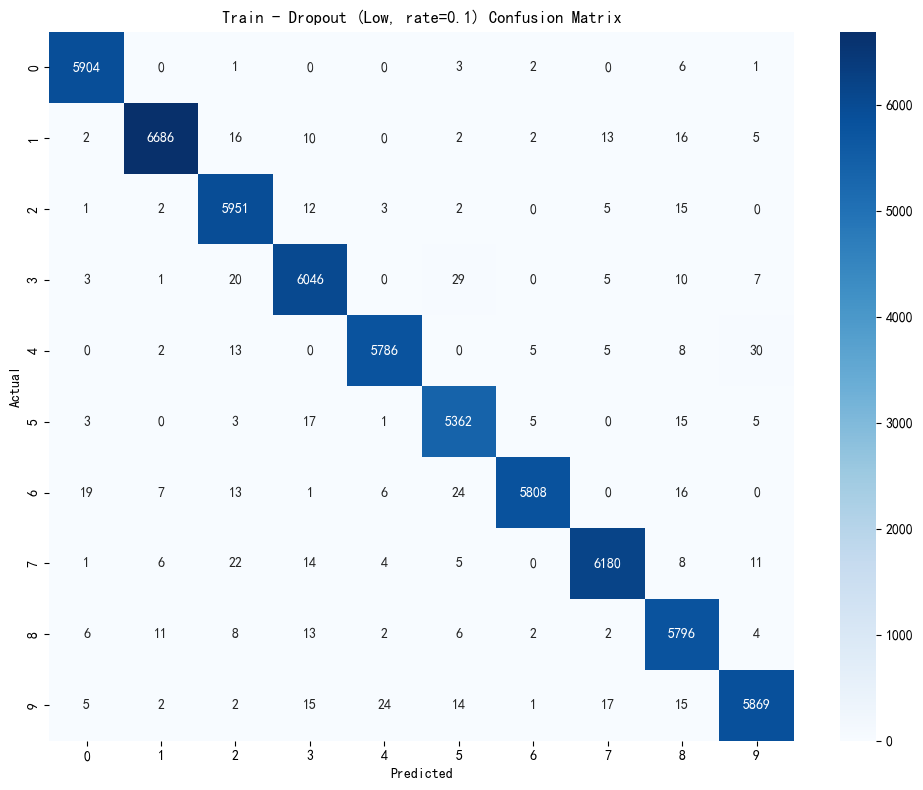


Test - Dropout (Low, rate=0.1) Evaluation Results:
Accuracy: 0.9768

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       986
           1       0.99      0.99      0.99      1125
           2       0.98      0.98      0.98       999
           3       0.97      0.98      0.97      1020
           4       0.98      0.97      0.97       975
           5       0.97      0.98      0.97       902
           6       0.99      0.98      0.99       982
           7       0.99      0.97      0.98      1042
           8       0.96      0.96      0.96       975
           9       0.96      0.96      0.96       994

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



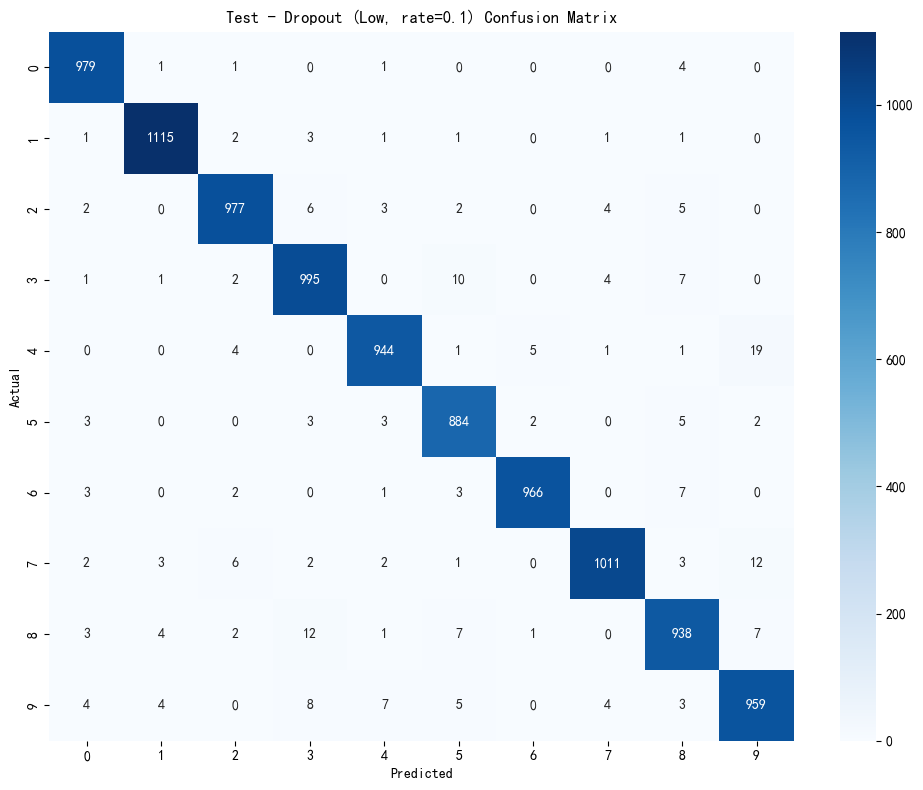

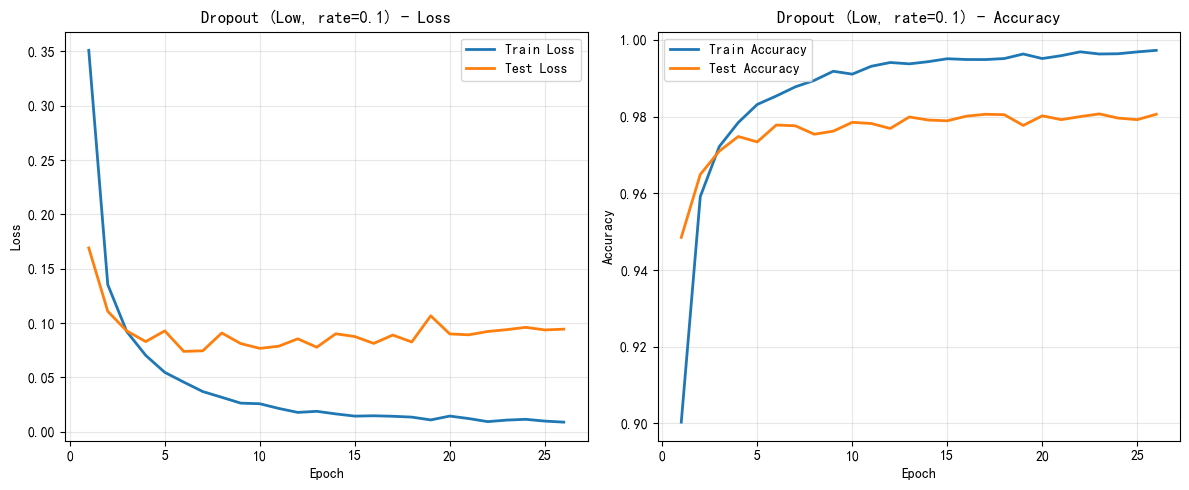


训练配置: Dropout (Medium, rate=0.3)
Epoch [10/100], Train Loss: 0.0416, Train Acc: 0.9860, Test Loss: 0.0838, Test Acc: 0.9749
Epoch [20/100], Train Loss: 0.0238, Train Acc: 0.9918, Test Loss: 0.0975, Test Acc: 0.9770
Epoch [30/100], Train Loss: 0.0168, Train Acc: 0.9944, Test Loss: 0.1133, Test Acc: 0.9740
Early stopping triggered at epoch 30, best Test Loss:0.0838 at epoch 9 

Train - Dropout (Medium, rate=0.3) Evaluation Results:
Accuracy: 0.9888

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5917
           1       1.00      0.99      0.99      6752
           2       0.99      0.99      0.99      5991
           3       0.99      0.98      0.99      6121
           4       0.99      0.99      0.99      5849
           5       0.99      0.99      0.99      5411
           6       1.00      0.99      0.99      5894
           7       0.99      0.98      0.99      6251
           8       0.98      0.99    

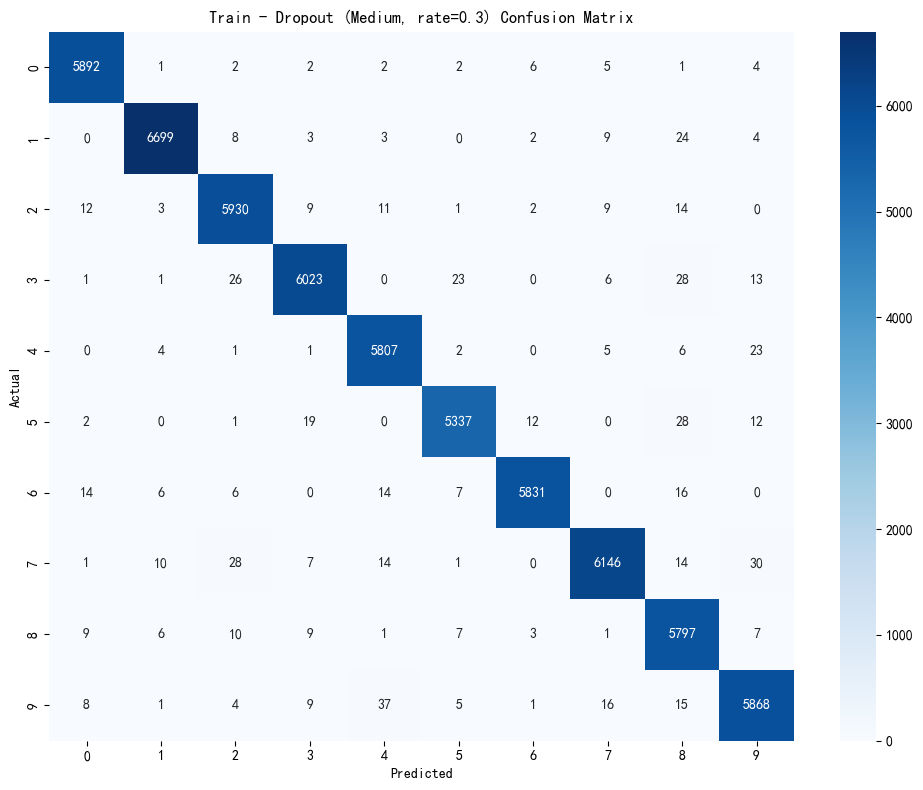


Test - Dropout (Medium, rate=0.3) Evaluation Results:
Accuracy: 0.9748

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       986
           1       0.99      0.99      0.99      1125
           2       0.98      0.97      0.98       999
           3       0.97      0.97      0.97      1020
           4       0.97      0.97      0.97       975
           5       0.98      0.96      0.97       902
           6       0.99      0.98      0.99       982
           7       0.98      0.97      0.98      1042
           8       0.95      0.97      0.96       975
           9       0.96      0.96      0.96       994

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



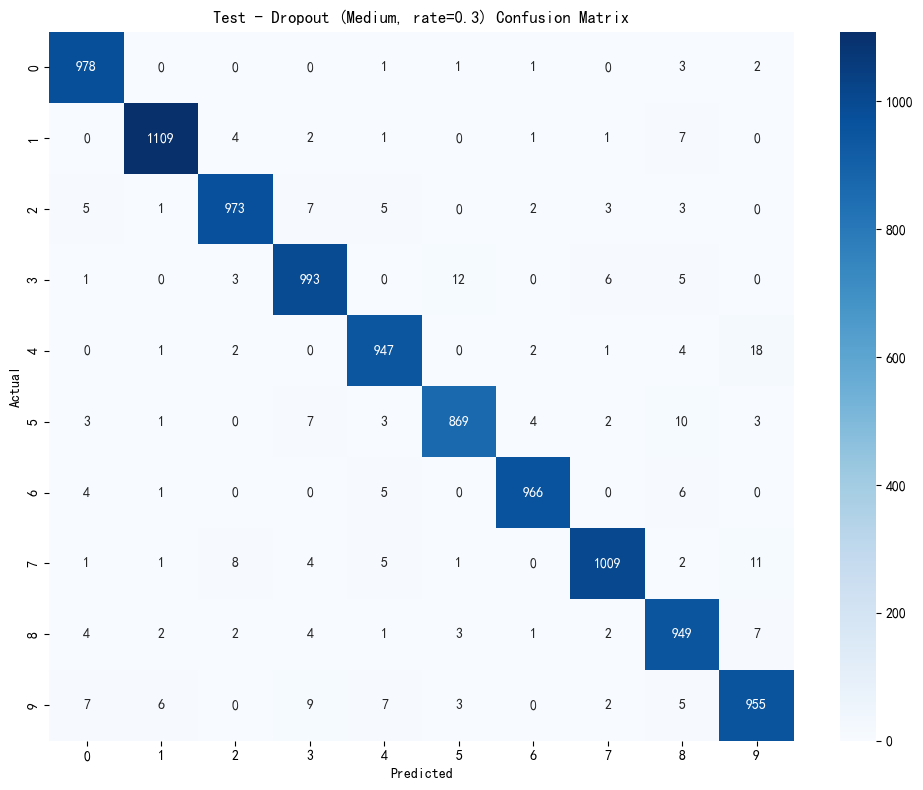

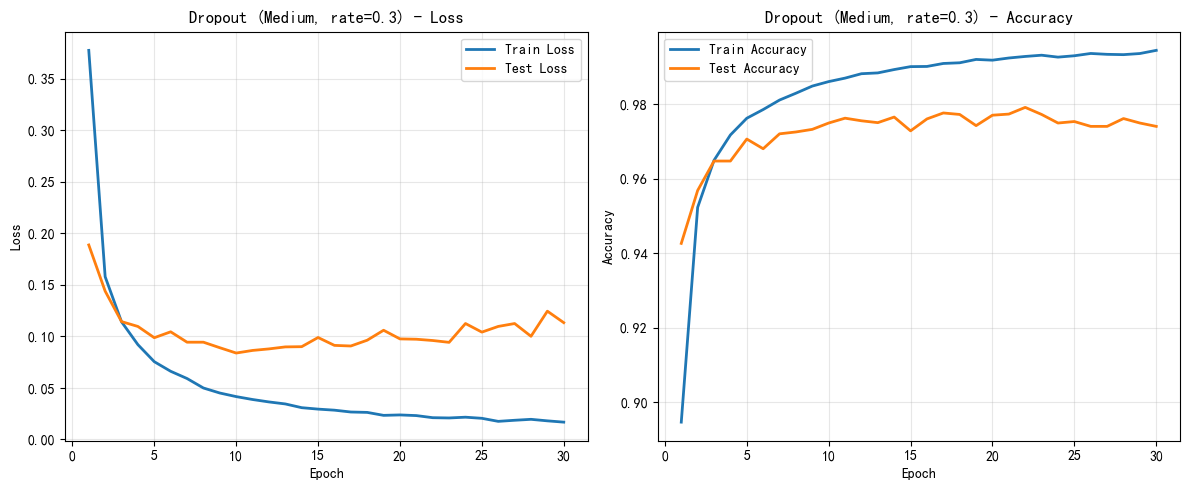


训练配置: Dropout (High, rate=0.5)
Epoch [10/100], Train Loss: 0.0731, Train Acc: 0.9766, Test Loss: 0.1053, Test Acc: 0.9684
Epoch [20/100], Train Loss: 0.0492, Train Acc: 0.9840, Test Loss: 0.1037, Test Acc: 0.9711
Epoch [30/100], Train Loss: 0.0393, Train Acc: 0.9868, Test Loss: 0.0996, Test Acc: 0.9727
Epoch [40/100], Train Loss: 0.0337, Train Acc: 0.9885, Test Loss: 0.1062, Test Acc: 0.9752
Early stopping triggered at epoch 48, best Test Loss:0.0987 at epoch 27 

Train - Dropout (High, rate=0.5) Evaluation Results:
Accuracy: 0.9887

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5917
           1       0.99      0.99      0.99      6752
           2       0.99      0.98      0.99      5991
           3       0.99      0.98      0.98      6121
           4       0.99      0.99      0.99      5849
           5       0.99      0.99      0.99      5411
           6       0.99      0.99      0.99      5894
   

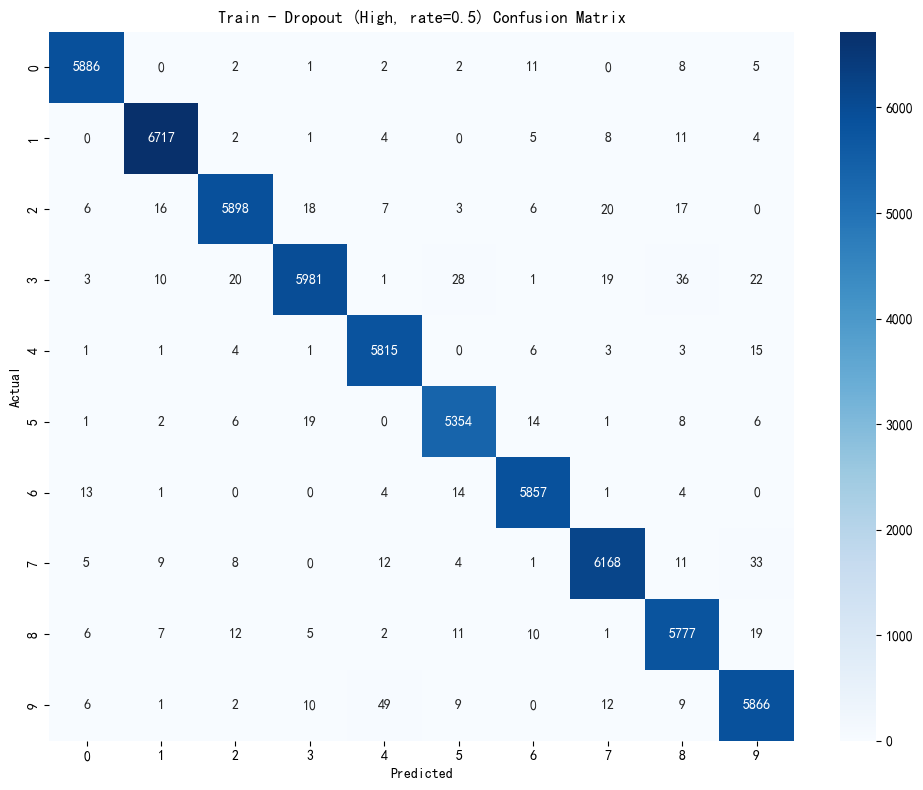


Test - Dropout (High, rate=0.5) Evaluation Results:
Accuracy: 0.9731

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       986
           1       0.98      0.99      0.99      1125
           2       0.99      0.97      0.98       999
           3       0.98      0.95      0.96      1020
           4       0.96      0.98      0.97       975
           5       0.97      0.97      0.97       902
           6       0.98      0.99      0.99       982
           7       0.97      0.97      0.97      1042
           8       0.97      0.96      0.97       975
           9       0.95      0.96      0.95       994

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



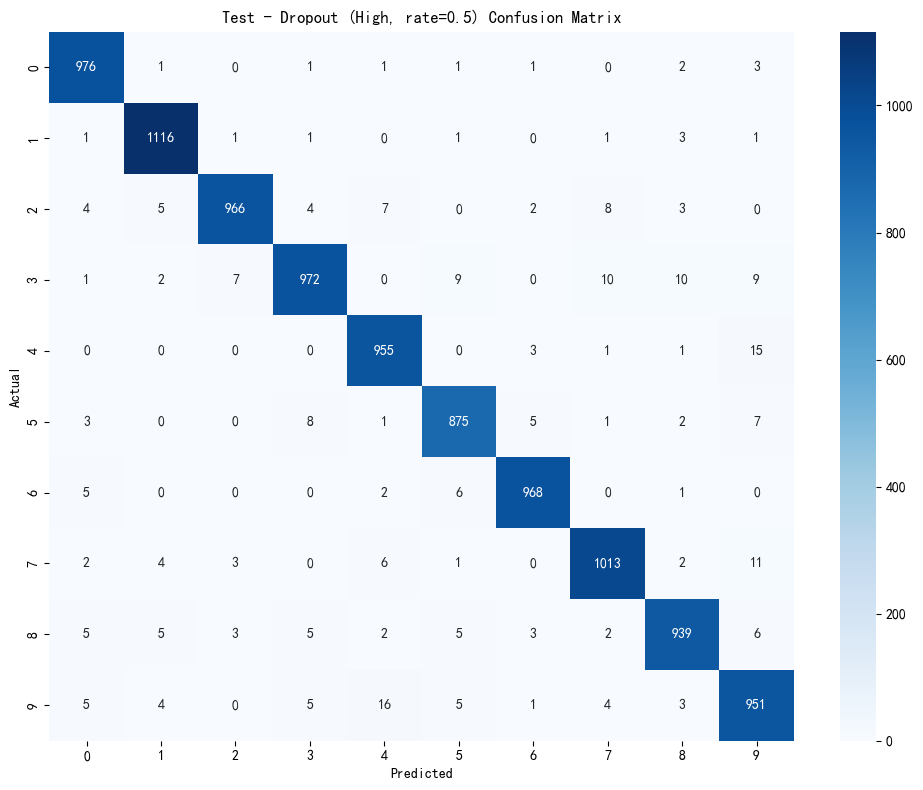

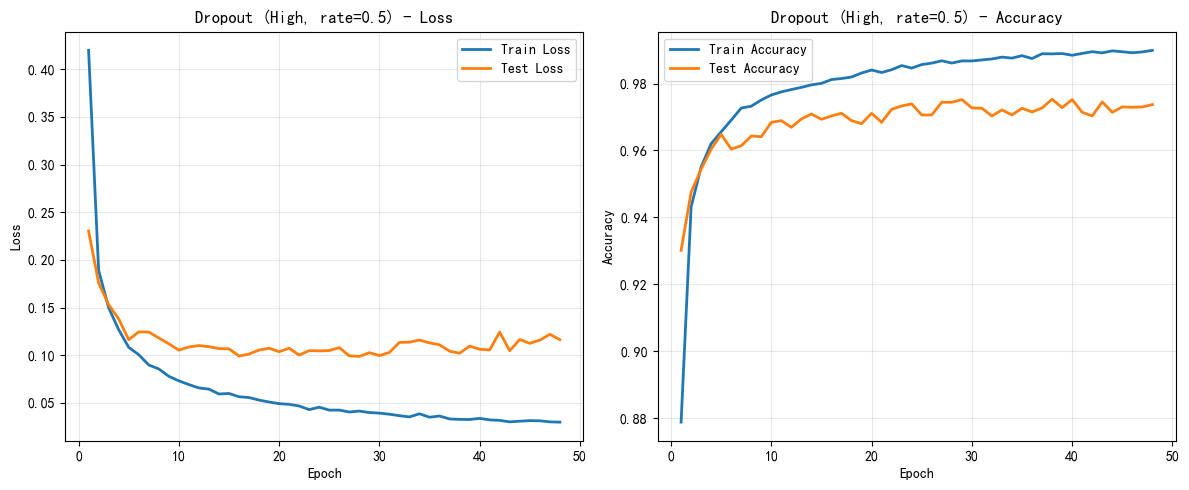


训练配置: L2 Regularization (Weak, lambda=0.0001)
Epoch [10/100], Train Loss: 0.0512, Train Acc: 0.9929, Test Loss: 0.1015, Test Acc: 0.9797
Epoch [20/100], Train Loss: 0.0408, Train Acc: 0.9966, Test Loss: 0.1028, Test Acc: 0.9804
Early stopping triggered at epoch 27, best Test Loss:0.0966 at epoch 6 

Train - L2 Regularization (Weak, lambda=0.0001) Evaluation Results:
Accuracy: 0.9937

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5917
           1       1.00      0.99      0.99      6752
           2       0.99      1.00      0.99      5991
           3       1.00      0.99      0.99      6121
           4       0.99      1.00      0.99      5849
           5       0.99      0.99      0.99      5411
           6       0.99      1.00      0.99      5894
           7       0.99      0.99      0.99      6251
           8       0.99      0.99      0.99      5850
           9       0.99      0.99      0.99     

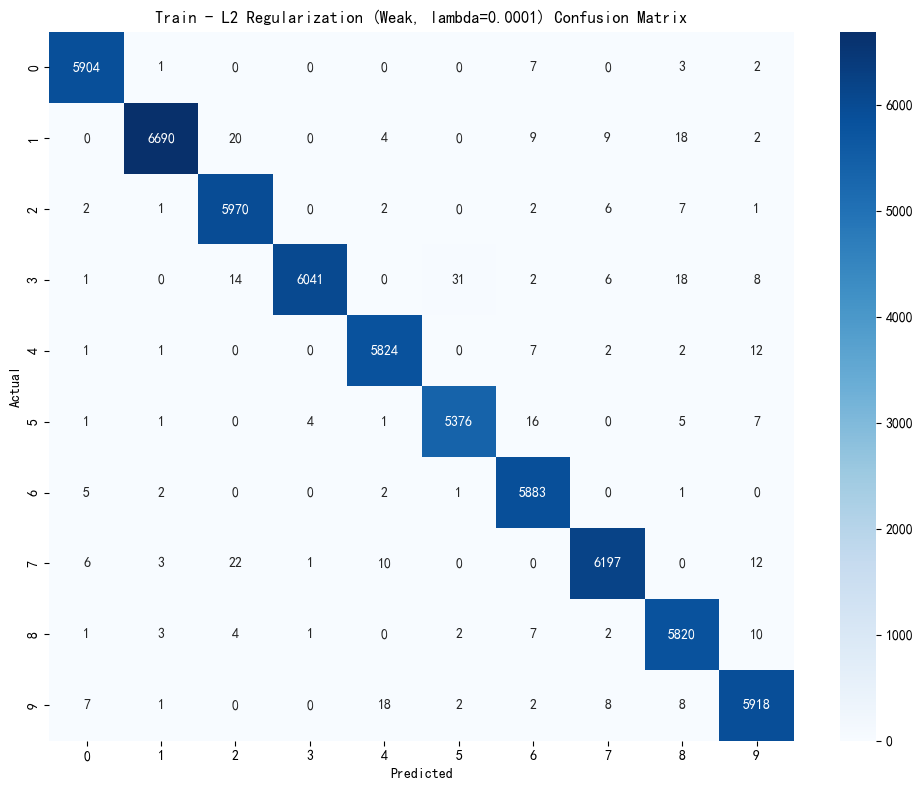


Test - L2 Regularization (Weak, lambda=0.0001) Evaluation Results:
Accuracy: 0.9794

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       986
           1       0.99      0.99      0.99      1125
           2       0.98      0.98      0.98       999
           3       0.99      0.97      0.98      1020
           4       0.98      0.98      0.98       975
           5       0.98      0.98      0.98       902
           6       0.98      0.99      0.99       982
           7       0.99      0.97      0.98      1042
           8       0.97      0.97      0.97       975
           9       0.96      0.97      0.97       994

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



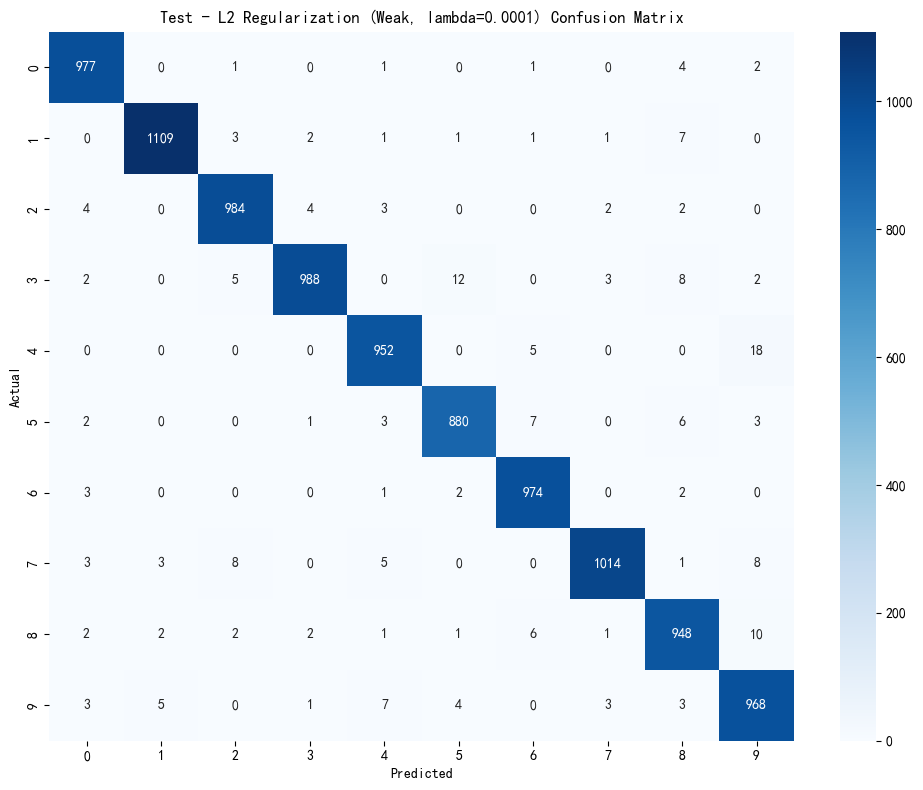

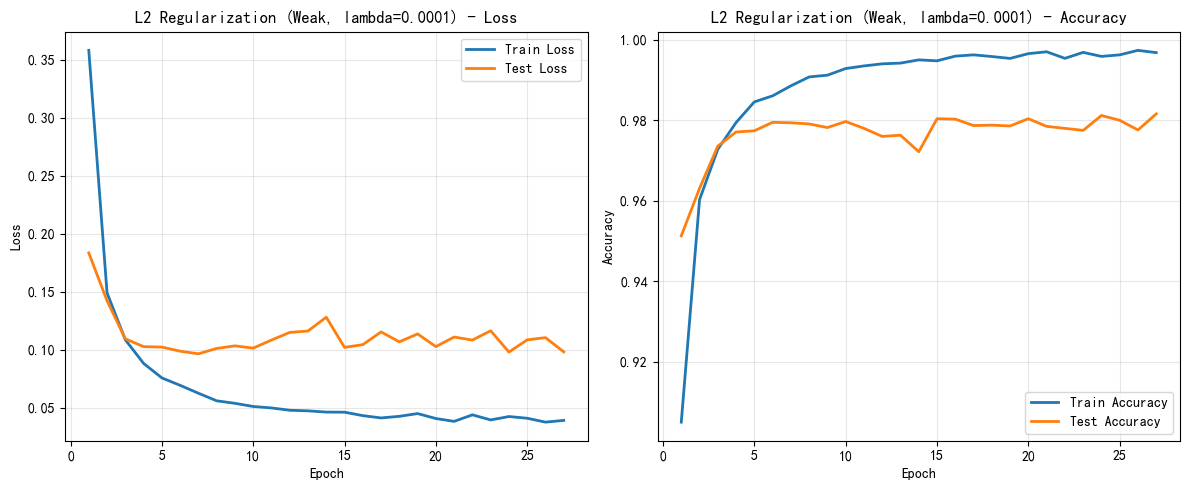


训练配置: L2 Regularization (Medium, lambda=0.001)
Epoch [10/100], Train Loss: 0.1517, Train Acc: 0.9825, Test Loss: 0.1673, Test Acc: 0.9779
Epoch [20/100], Train Loss: 0.1374, Train Acc: 0.9863, Test Loss: 0.1664, Test Acc: 0.9761
Epoch [30/100], Train Loss: 0.1363, Train Acc: 0.9866, Test Loss: 0.1673, Test Acc: 0.9766
Epoch [40/100], Train Loss: 0.1331, Train Acc: 0.9880, Test Loss: 0.1542, Test Acc: 0.9797
Epoch [50/100], Train Loss: 0.1335, Train Acc: 0.9873, Test Loss: 0.1551, Test Acc: 0.9809
Epoch [60/100], Train Loss: 0.1319, Train Acc: 0.9879, Test Loss: 0.1623, Test Acc: 0.9771
Early stopping triggered at epoch 60, best Test Loss:0.1542 at epoch 39 

Train - L2 Regularization (Medium, lambda=0.001) Evaluation Results:
Accuracy: 0.9913

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5917
           1       0.99      0.99      0.99      6752
           2       0.99      0.99      0.99      5991
     

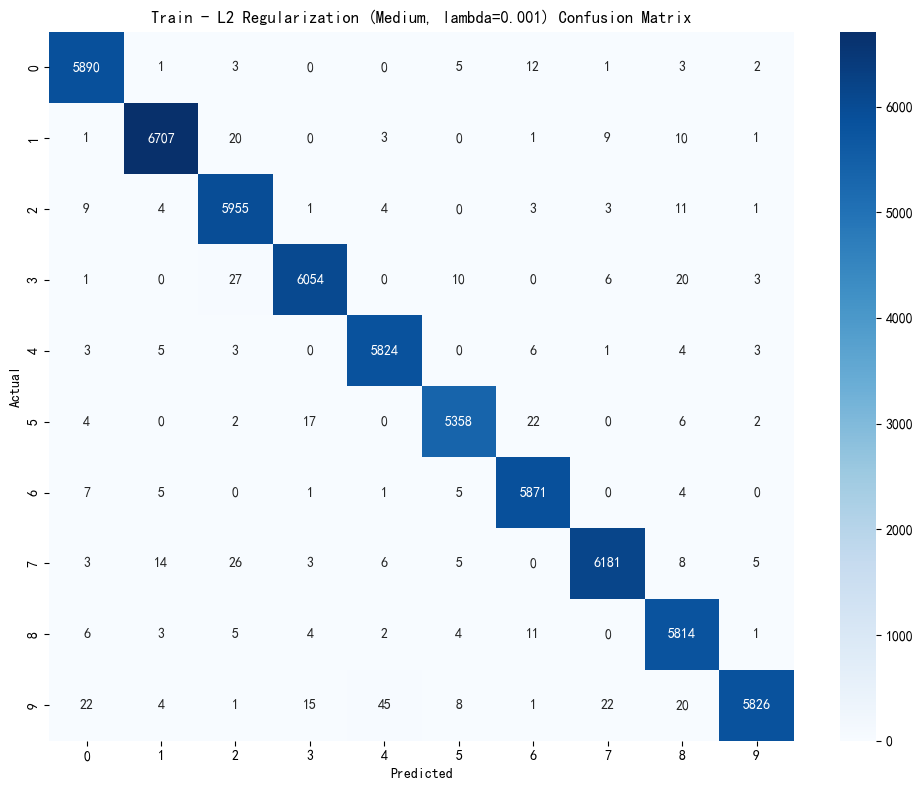


Test - L2 Regularization (Medium, lambda=0.001) Evaluation Results:
Accuracy: 0.9797

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       986
           1       0.99      0.99      0.99      1125
           2       0.98      0.98      0.98       999
           3       0.97      0.97      0.97      1020
           4       0.98      0.98      0.98       975
           5       0.98      0.98      0.98       902
           6       0.98      1.00      0.99       982
           7       0.99      0.98      0.98      1042
           8       0.97      0.98      0.97       975
           9       0.98      0.95      0.97       994

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



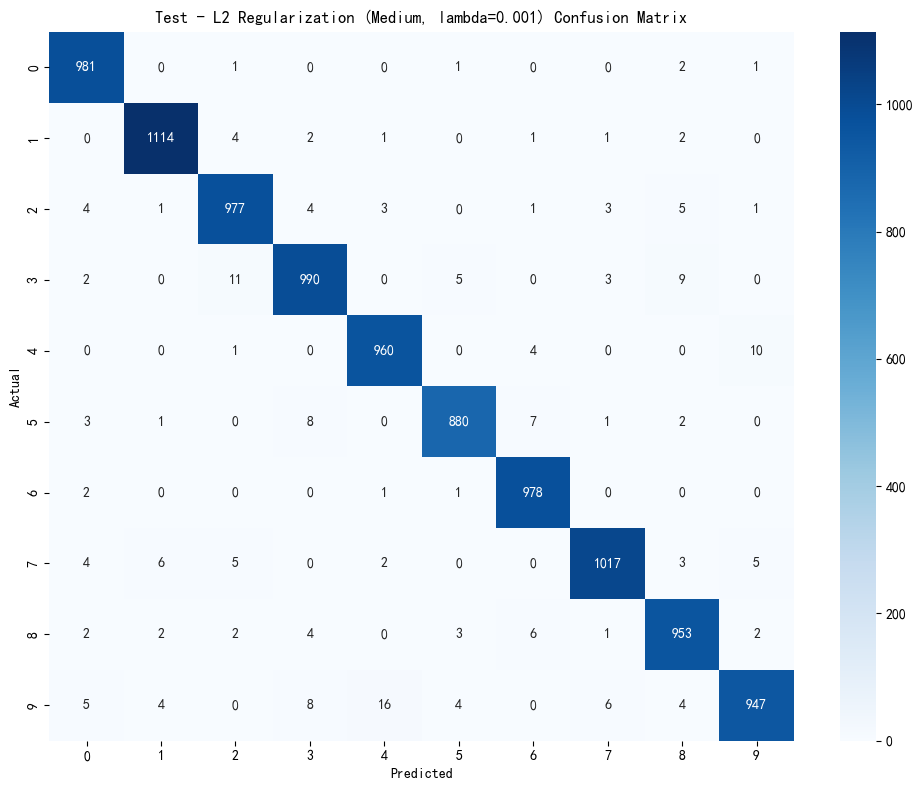

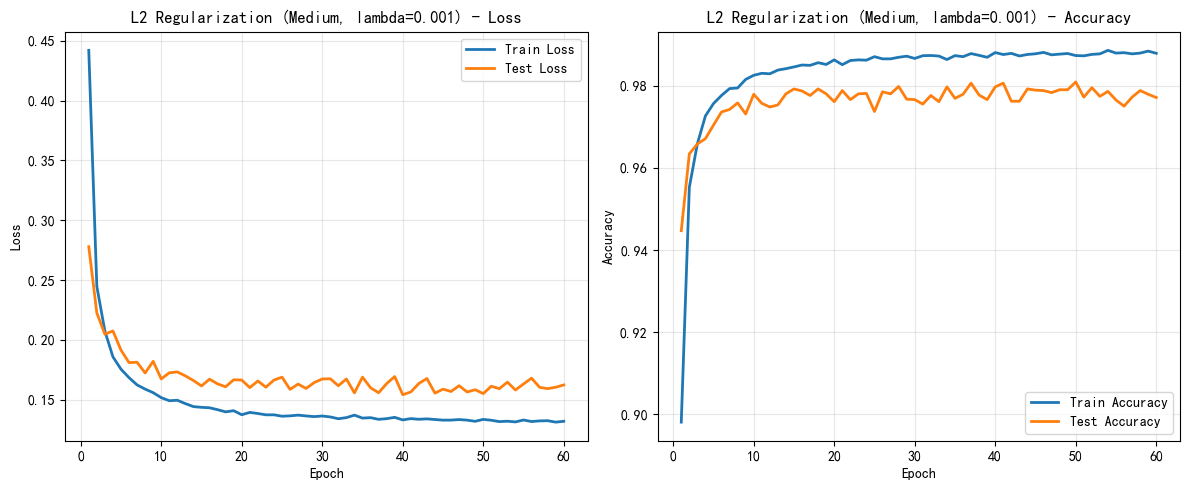


训练配置: L2 Regularization (Strong, lambda=0.01)
Epoch [10/100], Train Loss: 0.5277, Train Acc: 0.9442, Test Loss: 0.5289, Test Acc: 0.9430
Epoch [20/100], Train Loss: 0.5192, Train Acc: 0.9473, Test Loss: 0.5178, Test Acc: 0.9478
Epoch [30/100], Train Loss: 0.5170, Train Acc: 0.9473, Test Loss: 0.5128, Test Acc: 0.9498
Epoch [40/100], Train Loss: 0.5144, Train Acc: 0.9479, Test Loss: 0.5157, Test Acc: 0.9472
Epoch [50/100], Train Loss: 0.5152, Train Acc: 0.9482, Test Loss: 0.5113, Test Acc: 0.9495
Epoch [60/100], Train Loss: 0.5148, Train Acc: 0.9485, Test Loss: 0.5145, Test Acc: 0.9493
Epoch [70/100], Train Loss: 0.5131, Train Acc: 0.9484, Test Loss: 0.5140, Test Acc: 0.9473
Epoch [80/100], Train Loss: 0.5129, Train Acc: 0.9482, Test Loss: 0.5167, Test Acc: 0.9467
Epoch [90/100], Train Loss: 0.5123, Train Acc: 0.9493, Test Loss: 0.5195, Test Acc: 0.9452
Early stopping triggered at epoch 98, best Test Loss:0.5097 at epoch 77 

Train - L2 Regularization (Strong, lambda=0.01) Evaluation R

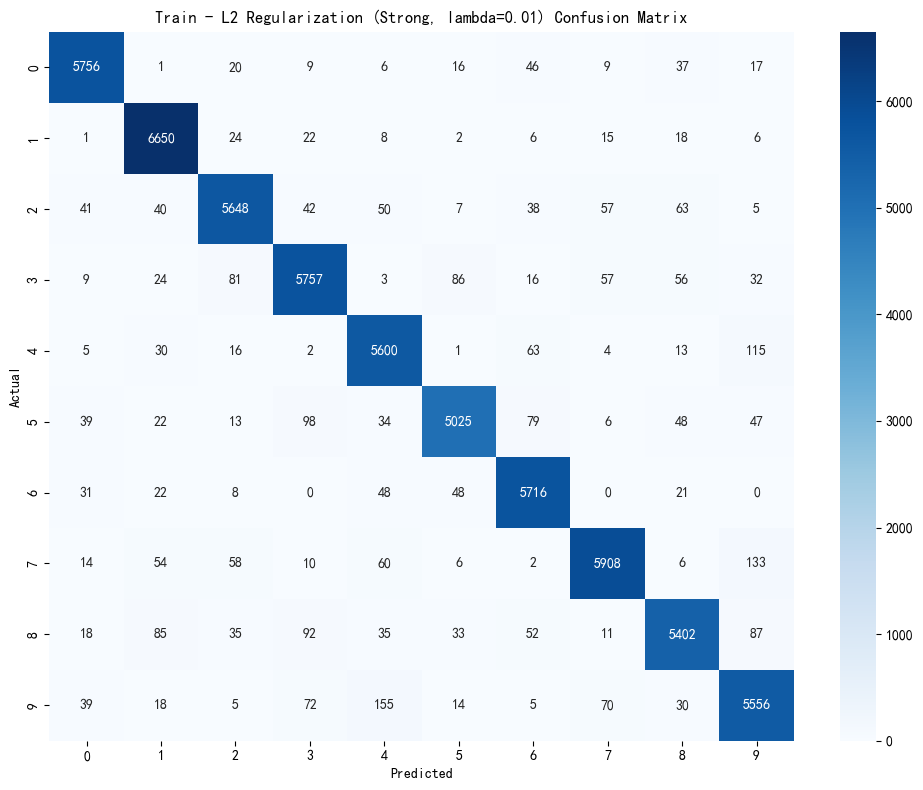


Test - L2 Regularization (Strong, lambda=0.01) Evaluation Results:
Accuracy: 0.9484

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       986
           1       0.96      0.98      0.97      1125
           2       0.96      0.94      0.95       999
           3       0.94      0.93      0.94      1020
           4       0.95      0.95      0.95       975
           5       0.96      0.94      0.95       902
           6       0.95      0.98      0.96       982
           7       0.96      0.95      0.95      1042
           8       0.94      0.91      0.93       975
           9       0.91      0.92      0.91       994

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



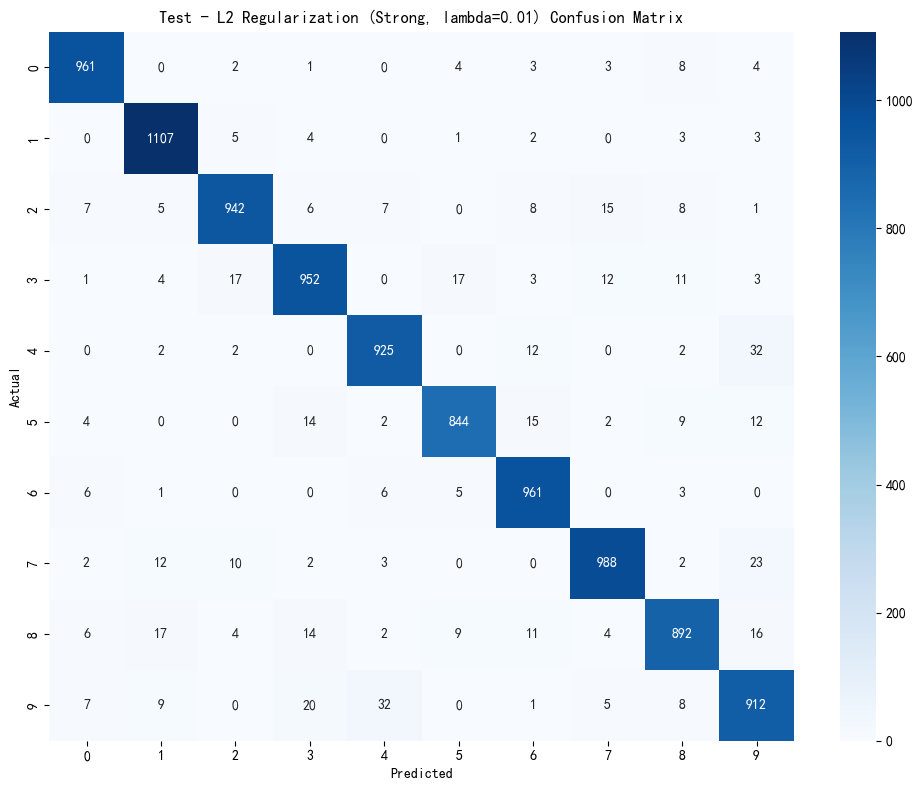

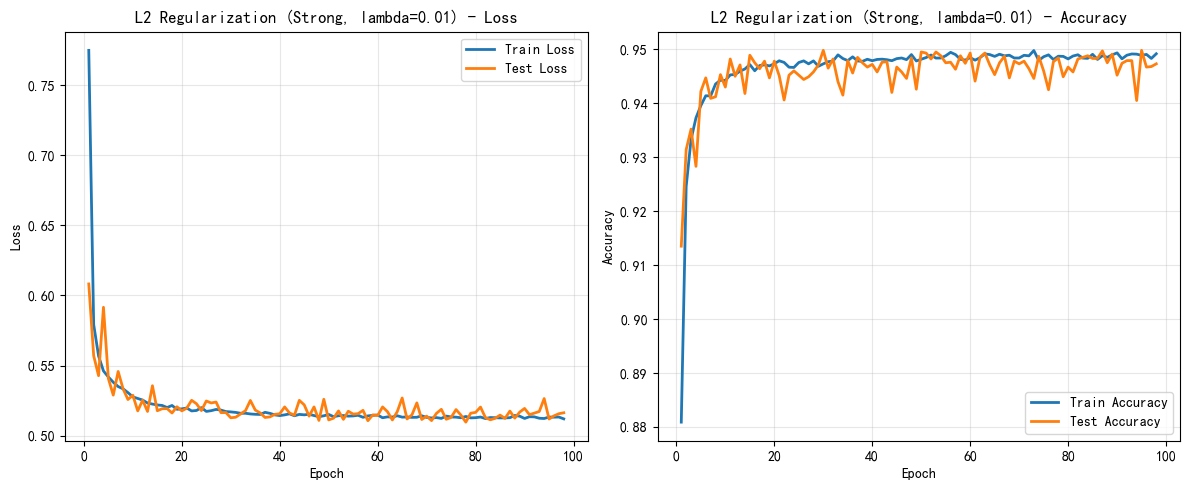

In [17]:
# 加载和预处理MNIST数据
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(int)

# 数据预处理
X = X / 255.0

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, train_size=60000, random_state=42, stratify=y
)

# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"训练集形状: X={X_train.shape}, y={y_train.shape}")
print(f"测试集形状: X={X_test.shape}, y={y_test.shape}")

# 对比实验配置
experiments = [
    {
        'name': 'Baseline (ReLU, No Regularization)',
        'activation': 'relu',
        'dropout_rate': 0.0,
        'use_l2_regularization': False,
        'l2_lambda': 0.0
    },
    {
        'name': 'Sigmoid Activation (No Regularization)',
        'activation': 'sigmoid',
        'dropout_rate': 0.0,
        'use_l2_regularization': False,
        'l2_lambda': 0.0
    },
    {
        'name': 'Tanh Activation (No Regularization)',
        'activation': 'tanh',
        'dropout_rate': 0.0,
        'use_l2_regularization': False,
        'l2_lambda': 0.0
    },
    {
        'name': 'Dropout (Low, rate=0.1)',
        'activation': 'relu',
        'dropout_rate': 0.1,
        'use_l2_regularization': False,
        'l2_lambda': 0.0
    },
    {
        'name': 'Dropout (Medium, rate=0.3)',
        'activation': 'relu',
        'dropout_rate': 0.3,
        'use_l2_regularization': False,
        'l2_lambda': 0.0
    },
    {
        'name': 'Dropout (High, rate=0.5)',
        'activation': 'relu',
        'dropout_rate': 0.5,
        'use_l2_regularization': False,
        'l2_lambda': 0.0
    },
    {
        'name': 'L2 Regularization (Weak, lambda=0.0001)',
        'activation': 'relu',
        'dropout_rate': 0.0,
        'use_l2_regularization': True,
        'l2_lambda': 0.0001
    },
    {
        'name': 'L2 Regularization (Medium, lambda=0.001)',
        'activation': 'relu',
        'dropout_rate': 0.0,
        'use_l2_regularization': True,
        'l2_lambda': 0.001
    },
    {
        'name': 'L2 Regularization (Strong, lambda=0.01)',
        'activation': 'relu',
        'dropout_rate': 0.0,
        'use_l2_regularization': True,
        'l2_lambda': 0.01
    }
]

# 运行对比实验
results = {}
histories = {}

print("开始对比实验...")
for config in experiments:
    print(f"\n{'='*50}")
    print(f"训练配置: {config['name']}")
    print(f"{'='*50}")
    
    # 创建模型
    model = FeedForwardNetMNIST(
        input_dim=784,
        hidden_dims=[256, 128],  # 两层隐藏层
        output_dim=10,
        activation=config['activation'],
        dropout_rate=config['dropout_rate'],
        use_manual_dropout=True,
        use_l2_regularization=config['use_l2_regularization'],
        l2_lambda=config['l2_lambda']
    ).to(device)
    
    # 训练模型
    history = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=100,
        learning_rate=0.001,
        verbose=True,
        early_stopping=True,
        patience=20
    )
    
    # 评估模型
    train_acc = evaluate_model(model, X_train_tensor, y_train_tensor, f"Train - {config['name']}")
    test_acc = evaluate_model(model, X_test_tensor, y_test_tensor, f"Test - {config['name']}")
    
    # 保存结果
    results[config['name']] = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'final_train_loss': history['train_loss'][-1],
        'final_test_loss': history['test_loss'][-1]
    }
    histories[config['name']] = history
    
    # 绘制训练历史
    plot_training_history(history, config['name'])


In [18]:
# 结果总结
print("\n" + "="*80)
print("对比实验结果总结")
print("="*80)

for config_name, result in results.items():
    print(f"\n{config_name}:")
    print(f"  训练准确率: {result['train_accuracy']:.4f}")
    print(f"  测试准确率: {result['test_accuracy']:.4f}")
    print(f"  泛化差距: {result['train_accuracy'] - result['test_accuracy']:.4f}")
    print(f"  最终训练损失: {result['final_train_loss']:.4f}")
    print(f"  最终测试损失: {result['final_test_loss']:.4f}")

# 绘制所有实验的对比图
def plot_comparison(histories, results, title_prefix="Comparison"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 准确率对比
    for config_name, history in histories.items():
        ax1.plot(history['epochs'], history['test_acc'], label=config_name, linewidth=2)
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Test Accuracy')
    ax1.set_title(f'{title_prefix} - Test Accuracy Curve')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 最终性能对比
    config_names = list(results.keys())
    train_accs = [results[name]['train_accuracy'] for name in config_names]
    test_accs = [results[name]['test_accuracy'] for name in config_names]
    
    x = np.arange(len(config_names))
    width = 0.35
    
    ax2.bar(x - width/2, train_accs, width, label='Train Accuracy', alpha=0.7)
    ax2.bar(x + width/2, test_accs, width, label='Test Accuracy', alpha=0.7)
    
    ax2.set_xlabel('Configuration')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{title_prefix} - Final Performance')
    ax2.set_xticks(x)
    ax2.set_xticklabels([name.split('(')[0].strip() for name in config_names], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()




对比实验结果总结

Baseline (ReLU, No Regularization):
  训练准确率: 0.9933
  测试准确率: 0.9780
  泛化差距: 0.0153
  最终训练损失: 0.0075
  最终测试损失: 0.0942

Sigmoid Activation (No Regularization):
  训练准确率: 0.9971
  测试准确率: 0.9787
  泛化差距: 0.0184
  最终训练损失: 0.0102
  最终测试损失: 0.0915

Tanh Activation (No Regularization):
  训练准确率: 0.9942
  测试准确率: 0.9771
  泛化差距: 0.0171
  最终训练损失: 0.0001
  最终测试损失: 0.0835

Dropout (Low, rate=0.1):
  训练准确率: 0.9898
  测试准确率: 0.9768
  泛化差距: 0.0130
  最终训练损失: 0.0087
  最终测试损失: 0.0943

Dropout (Medium, rate=0.3):
  训练准确率: 0.9888
  测试准确率: 0.9748
  泛化差距: 0.0140
  最终训练损失: 0.0168
  最终测试损失: 0.1133

Dropout (High, rate=0.5):
  训练准确率: 0.9887
  测试准确率: 0.9731
  泛化差距: 0.0156
  最终训练损失: 0.0298
  最终测试损失: 0.1164

L2 Regularization (Weak, lambda=0.0001):
  训练准确率: 0.9937
  测试准确率: 0.9794
  泛化差距: 0.0143
  最终训练损失: 0.0392
  最终测试损失: 0.0983

L2 Regularization (Medium, lambda=0.001):
  训练准确率: 0.9913
  测试准确率: 0.9797
  泛化差距: 0.0116
  最终训练损失: 0.1319
  最终测试损失: 0.1623

L2 Regularization (Strong, lambda=0.01):
  训练准确率: 0.9503
 

正在绘制: 不同激活函数对比 (Activation Functions)


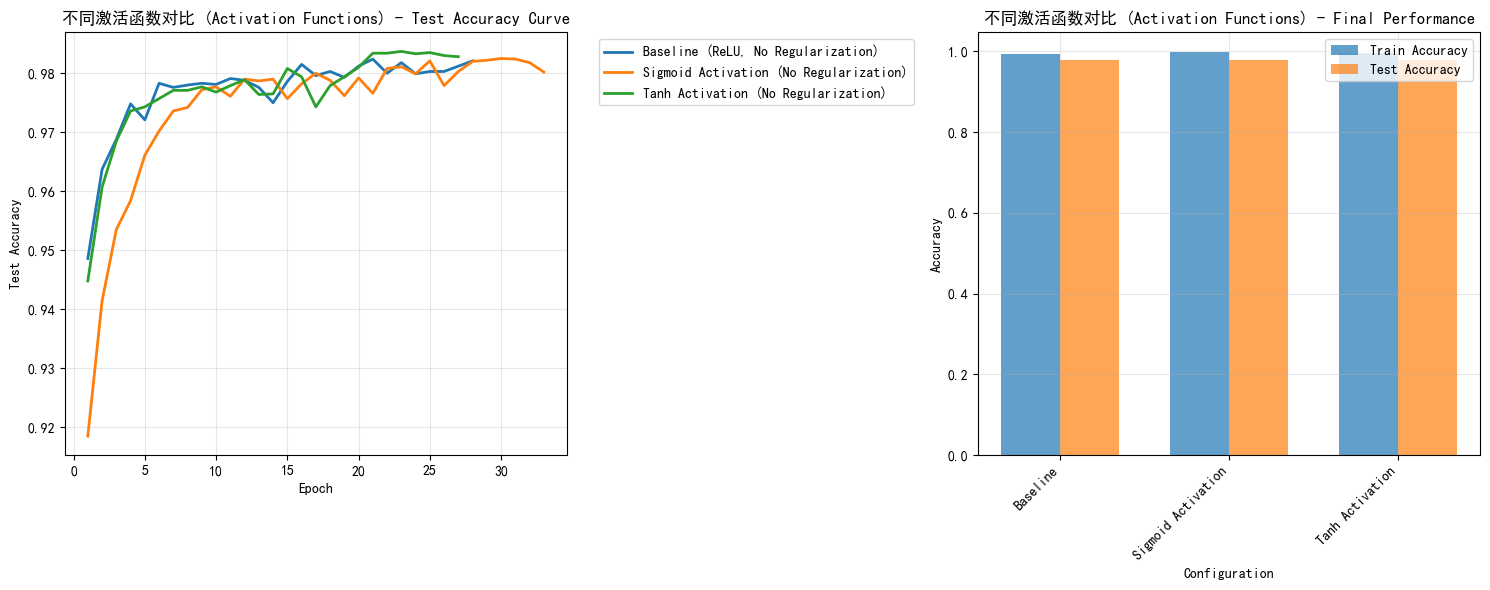

正在绘制: 不同 Dropout 强度对比 (Dropout Rates)


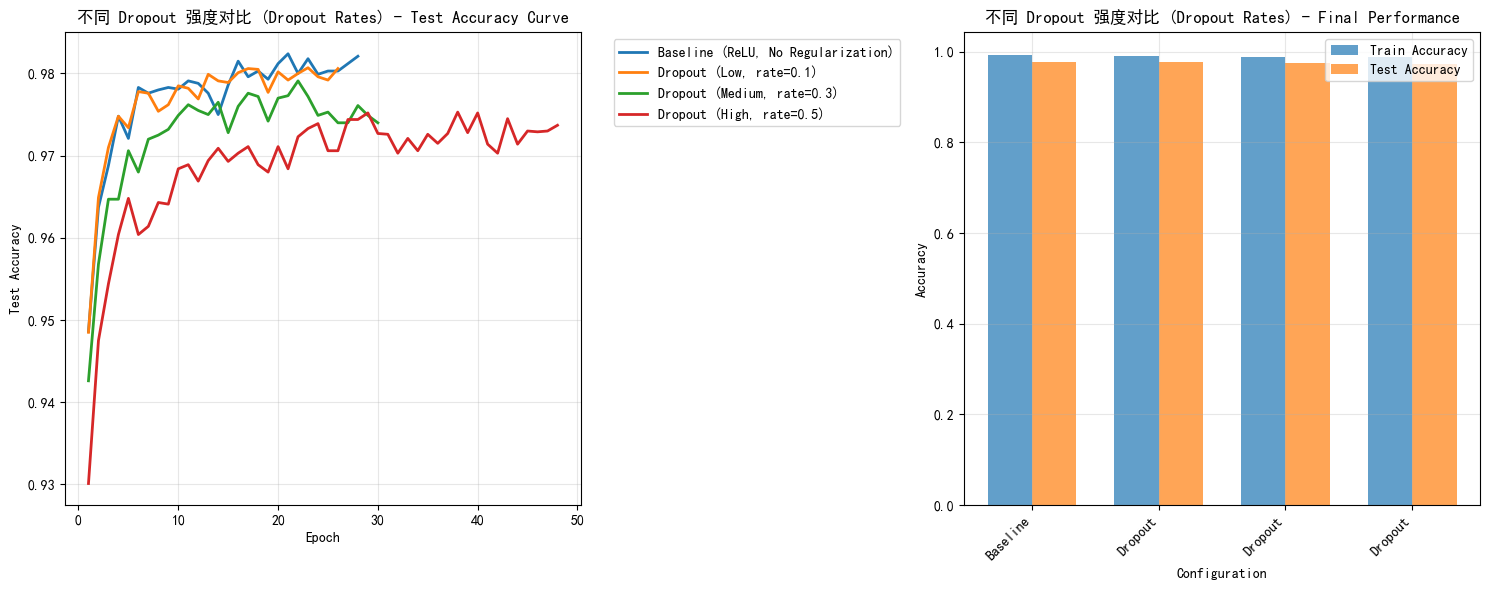

正在绘制: 不同 L2 正则化强度对比 (L2 Regularization)


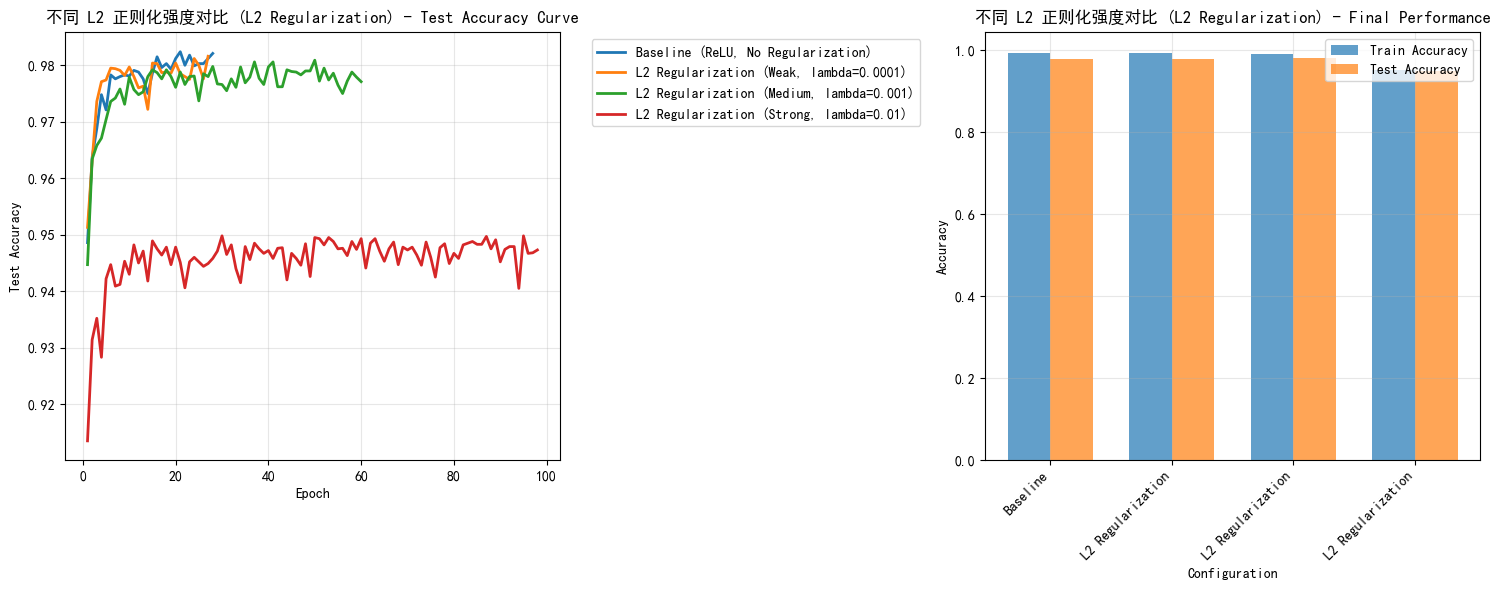

In [19]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
groups = {
    "不同激活函数对比 (Activation Functions)": [
        'Baseline (ReLU, No Regularization)',
        'Sigmoid Activation (No Regularization)',
        'Tanh Activation (No Regularization)'
    ],
    
    "不同 Dropout 强度对比 (Dropout Rates)": [
        'Baseline (ReLU, No Regularization)',
        'Dropout (Low, rate=0.1)',
        'Dropout (Medium, rate=0.3)',
        'Dropout (High, rate=0.5)'
    ],
    
    "不同 L2 正则化强度对比 (L2 Regularization)": [
        'Baseline (ReLU, No Regularization)',
        'L2 Regularization (Weak, lambda=0.0001)',
        'L2 Regularization (Medium, lambda=0.001)',
        'L2 Regularization (Strong, lambda=0.01)'
    ]
}
for group_name, target_keys in groups.items():
    print(f"正在绘制: {group_name}")
    
    subset_histories = {
        k: v for k, v in histories.items() 
        if k in target_keys
    }
    
    subset_results = {
        k: v for k, v in results.items() 
        if k in target_keys
    }
    if subset_histories:
        # 调用绘图函数，传入筛选后的子集
        plot_comparison(subset_histories, subset_results, title_prefix=group_name)
    else:
        print(f"⚠️ 警告: 组 '{group_name}' 未找到匹配的数据，请检查 Key 名称是否正确。")